# Create Tritium-$^3$He initial files for CESM1.2.2
Created by Ivan Lima on Wed Mar 23 15:48:49 EDT 2016

In [1]:
import numpy as np
import os, netCDF4
import matplotlib.pyplot as plt
from numpy import ma
from datetime import datetime
%matplotlib inline

## Get grid dimensions & land mask from ecosys init file

In [2]:
datadir = '/bali/data/ilima/cesm/cesm1_input/ocn/pop/gx1v6/ic'
infile = os.path.join(datadir,'ecosys_jan_IC_gx1v6_corrO2_Feb2013.nc')
fpin = netCDF4.Dataset(infile,'r')
nz   = len(fpin.dimensions['z_t'])
nlat = len(fpin.dimensions['nlat'])
nlon = len(fpin.dimensions['nlon'])
zt   = fpin.variables['z_t'][:]
tlat = fpin.variables['TLAT'][:]
tlon = fpin.variables['TLONG'][:]
alk  = fpin.variables['ALK'][:]

## Create tritium and $^3$He fields as function of latitude and depth

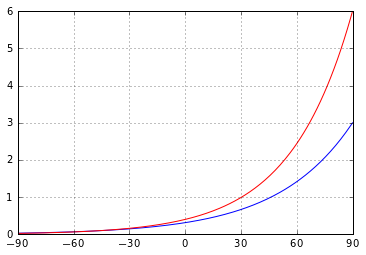

In [31]:
x  = np.linspace(-90,90,num=200)
y  = 0.001 * np.exp(0.025*x)
y2 = 0.001 * np.exp(0.03*x)
y  = y/y.max() * 3
y2 = y2/y2.max() * 6
fig, ax = plt.subplots()
ax.plot(x,y)
ax.plot(x,y2)
ax.set(xlim=(-90,90),xticks=np.arange(-90,120,30))
ax.grid('on')

### Surface tritium

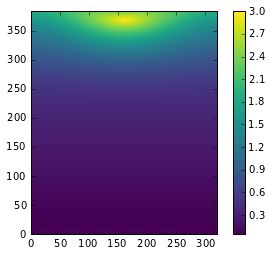

In [5]:
tr0 = 0.001 * np.exp(0.025*tlat)
tr0 = tr0/tr0.max() * 3
plt.imshow(tr0,origin='lower')
plt.colorbar()

### 3D tritium and $^3$He

In [6]:
z3d = np.ones(alk.shape) * zt[:,np.newaxis,np.newaxis]
tr = tr0[np.newaxis,:,:] * np.exp(-0.00003*z3d)
tr = ma.array(tr,mask=alk.mask)
#he3 = 1 - tr
he3 = ma.array(np.zeros(tr.shape),mask=alk.mask)

### Vertical profile

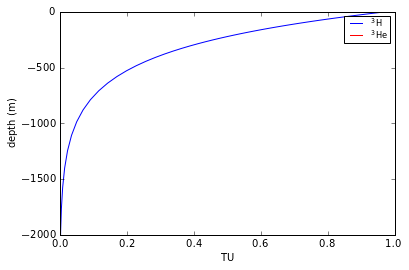

In [7]:
ii, jj = 300, 225
fig, ax = plt.subplots()
ax.plot(tr[:,ii,jj],-z3d[:,ii,jj]/100,label=r'$^3$H')
ax.plot(he3[:,ii,jj],-z3d[:,ii,jj]/100,label=r'$^3$He')
ax.set(ylim=(-2000,0),ylabel='depth (m)',xlabel='TU')
ax.legend()

### Vertical section

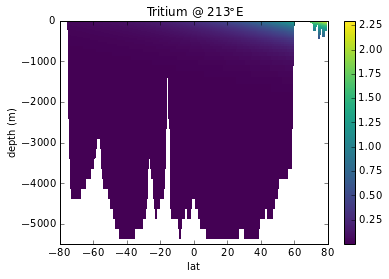

In [8]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(tlat[:,jj],-zt/100,tr[:,:,jj])
ax.set(ylim=(-5500,0),xlabel='lat',ylabel='depth (m)',title='Tritium @ %d$^\circ$E'%tlon[0,jj])
cb = fig.colorbar(pc)

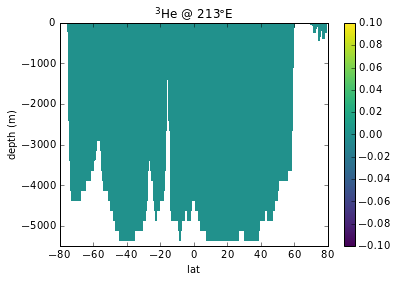

In [9]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(tlat[:,jj],-zt/100,he3[:,:,jj])
ax.set(ylim=(-5500,0),xlabel='lat',ylabel='depth (m)',title='$^3$He @ %d$^\circ$E'%tlon[0,jj])
cb = fig.colorbar(pc)

## Write fields to netCDF file

In [10]:
outfile = os.path.join(datadir,'tritium_3He_init_test.nc')
if os.path.isfile(outfile):
    os.remove(outfile)

fpout = netCDF4.Dataset(outfile,'w',format='NETCDF3_CLASSIC')
fpout.contents = 'Initial tritium and 3He fields for CESM'
fpout.history = 'Created by Ivan Lima <ivan@whoi.edu> on %s'%datetime.now().ctime()

for dim in ['z_t','nlat','nlon','Y','X']:
    fpout.createDimension(dim,len(fpin.dimensions[dim]))

for vname in ['z_t','TLAT','TLONG','KMT']:
    ncvar = fpout.createVariable(vname,fpin.variables[vname][:].dtype.char,fpin.variables[vname].dimensions)
    for attr in fpin.variables[vname].ncattrs():
        setattr(ncvar,attr,getattr(fpin.variables[vname],attr))
    ncvar[:] = fpin.variables[vname][:]
    
ncvar = fpout.createVariable('TRITIUM','f',('z_t','nlat','nlon'),fill_value=tr.fill_value)
ncvar.missing_value = tr.fill_value
ncvar.long_name = 'tritium'
ncvar.units = 'TU'
ncvar.coordinates = 'TLONG TLAT z_t time'
ncvar[:] = tr.astype(np.float32)

ncvar = fpout.createVariable('HELIUM3','f',('z_t','nlat','nlon'),fill_value=he3.fill_value)
ncvar.missing_value = he3.fill_value
ncvar.long_name = 'helium 3'
ncvar.units = 'TU'
ncvar.coordinates = 'TLONG TLAT z_t time'
ncvar[:] = he3.astype(np.float32)

fpin.close()
fpout.close()